In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import binom
from mpl_toolkits.mplot3d import Axes3D
import math
import scipy
from scipy.stats import pearsonr

## Task a

Load and explore the provided data. Compute the mean, standard deviation and median of the STAI-Y2
scores (trait anxiety).
Given a cutoff score of 43 (i.e. $ STAI ≤ 43 $ is healthy), how many participants would be considered healthy
controls?

(for the rest of the assignment we will consider the first 25 participants as the high anxious ones, and
the last 25 as the low anxious ones)

In [145]:
choices = pd.read_csv('inst_choices.csv', header=None)
outcomes = pd.read_csv('inst_outcomes.csv', header=None)
stai = pd.read_csv('stai_scores.csv', header=None)

In [146]:
for ind, row in choices.iterrows():
    trial = choices.iloc[ind]
    a_trial = trial[(trial==1)]
    print('participant %d chooses A in %d%% of the trials' % (ind + 1, len(a_trial) * 100 / len(trial)))

participant 1 chooses A in 18% of the trials
participant 2 chooses A in 25% of the trials
participant 3 chooses A in 34% of the trials
participant 4 chooses A in 9% of the trials
participant 5 chooses A in 28% of the trials
participant 6 chooses A in 22% of the trials
participant 7 chooses A in 34% of the trials
participant 8 chooses A in 24% of the trials
participant 9 chooses A in 18% of the trials
participant 10 chooses A in 20% of the trials
participant 11 chooses A in 27% of the trials
participant 12 chooses A in 16% of the trials
participant 13 chooses A in 16% of the trials
participant 14 chooses A in 20% of the trials
participant 15 chooses A in 26% of the trials
participant 16 chooses A in 24% of the trials
participant 17 chooses A in 9% of the trials
participant 18 chooses A in 14% of the trials
participant 19 chooses A in 30% of the trials
participant 20 chooses A in 30% of the trials
participant 21 chooses A in 17% of the trials
participant 22 chooses A in 25% of the trials

In [147]:
class ModelA:
    def _init_(self):
        self.alpha = 0
        self.beta = 0
        self.V = [0, 0]
        self.choices = []
        self.diff = [] # array of V_a - V_b
        self.averse = 0 # number of aversive signals received in a trial
        self.nnl = 0
    
    def action(self):
        if (np.exp(-self.beta*self.V[0]) + np.exp(-self.beta*self.V[1])) == 0:
            prob = 0
        else:
            prob = np.exp(-self.beta * self.V[0]) / (np.exp(-self.beta*self.V[0]) + np.exp(-self.beta*self.V[1]))
        # binom(1, 1-prob).rvs() returns 0 if A is chosen, and 1 if B is chosen
        choice = binom(1, 1-prob).rvs() + 1
        return choice
    
    def outcome(self, trial_ind, choice):
        noise_prob = [0.6, 0.8, 0.6, 0.65] # posibility of choosing A resulting in noise_prob
        if choice == 1:
            chance = noise_prob[math.floor((trial_ind / 40) % 4)]
        else:
            chance = 1 - noise_prob[math.floor((trial_ind / 40) % 4)]
        if binom(1, chance).rvs():
            self.averse += 1
            return 1
        else:
            return 0

    def update(self, choice, trial_ind):
        outcome = self.outcome(trial_ind, choice)
        self.V[choice - 1] = self.V[choice - 1]  + self.alpha * (outcome - self.V[choice - 1])
        return outcome

    def test_trial(self, trial_num, alpha, beta, va, vb):
        self.averse = 0
        self.choices = []
        self.outcomes = []
        self.diff = [] # Va - Vb
        self.alpha = alpha
        self.beta = beta
        self.V = [va, vb]

        for i in range(trial_num):
            choice = self.action()
            outcome = self.update(choice, i)
            self.choices.append(choice)
            self.outcomes.append(outcome)
            self.diff.append(self.V[0] - self.V[1])
        
        self.choices = np.array(self.choices)
        self.outcomes = np.array(self.outcomes)


    # calculate the negative log likelihood given the real data and some initial values
    def nll(self, parameters, choices, outcomes):
        choice_prob = []
        self.alpha = parameters[0]
        self.beta = parameters[1]
        self.V = [0.5, 0.5]

        for i in range(choices.size):
            real_choice = choices[i] - 1 # 0 for A and 1 for B
            if (np.exp(-self.beta*self.V[0]) + np.exp(-self.beta*self.V[1])) == 0:
                prob = 0
            else:
                prob = abs(real_choice - np.exp(-self.beta * self.V[0]) / (np.exp(-self.beta*self.V[0]) + np.exp(-self.beta*self.V[1])))
            choice_prob.append(prob)
            self.V[real_choice] = self.V[real_choice] + self.alpha * (outcomes[i] - self.V[real_choice])
        
        choice_prob = np.array(choice_prob)
        choice_prob[choice_prob == 0] = 0.0001
        nll = - np.sum(np.log(choice_prob))

        return nll

## Task b

*Simulate 160 choices with parameter settings α = 0.3, β = 8 and $V_0$ = 0.5 for both options a number of
times. (Choose a reasonable number so you can average the simulations). Illustrate the average evolution
of values $V_{(A)}$ and $V_{(B)}$. Illustrate the average evolution of the difference in V values of the two stimuli
(i.e. show how $V_{(A)}$ − $V_{(B)}$ changes, on average, over the course of the simulated experiments). Very briefly
explain what is observed and why the shape of this evolution makes sense.*

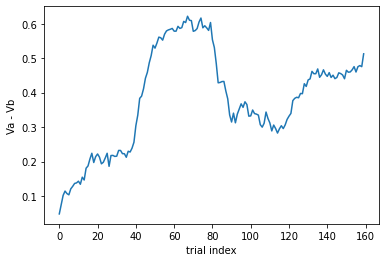

In [148]:
model = ModelA()
choices_all = []

for i in range(100):
    model.test_trial(160, alpha=0.3, beta=8, va=0.5, vb=0.5)
    choices_all.append(model.diff)

choices_all = np.array(choices_all)
choices_all = choices_all.mean(axis=0)

choices_all

plt.plot(choices_all)
plt.xlabel('trial index')
plt.ylabel('Va - Vb')
plt.show()

## Task C
*Simulate 160 choices several times for a number of different parameter settings. Systematically vary settings
of α and β to explore how different values affect the average number of aversive stimuli received. Plot the
average number of aversive stimuli received as a function of the parameter settings, which means there will
be three dimensions. Choose sensible ranges for the parameters*

*Briefly describe your precise approach and comment on how the expected performance during the experiment
is related to different settings of the parameters.*

Text(33.0, 0.5, 'beta')

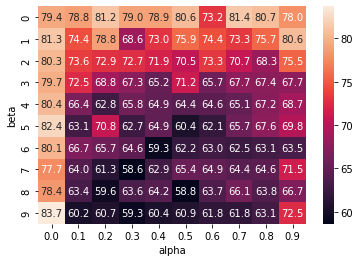

In [149]:
# store the averse stimulus received as 
data = pd.DataFrame(columns=[x/10 for x in range(0, 10, 1)], index=range(0, 10, 1), dtype=float)

for alpha in [x/10 for x in range(0, 10, 1)]:
    for beta in range(0, 10, 1):
        averse = []
        for i in range(10):
            model.test_trial(trial_num=160, alpha=alpha, beta=beta, va=0.5, vb=0.5)
            averse.append(model.averse)
        
        data.loc[beta][alpha] = np.array(averse).mean()

data.head(100)
sns.heatmap(data, annot=True, fmt='.1f')
plt.xlabel('alpha')
plt.ylabel('beta')

As can be seem from the heatmap above, 

## Task D Likelihood

*Report the NLL for the first and the 10th participant using parameter settings α = 0.3,β = 8,V0 = 0.5.*

In [150]:
model = ModelA()

print(model.nll([0.3, 8], choices.iloc[1], outcomes.iloc[1]))

64.24159844691494


In [151]:
model = ModelA()

for i in [0, 9]:
    print('The NLL of participant %d is %.2f' % (i+1, model.nll([0.3, 8], choices.iloc[i], outcomes.iloc[i])))

The NLL of participant 1 is 50.19
The NLL of participant 10 is 58.60


## Task E Model Fitting

*Find the parameters that minimize the NLL for each individual: Pass your NLL function and a set of starting
parameters (use α = 0.3 and β = 8) to a optimization function performing unconstrained minimization*

In [152]:
model = ModelA()
parameters = []

for i in range(50):
    choices_i = choices.iloc[i]
    outcomes_i = outcomes.iloc[i]
    # extract the optimized parameters
    parameters.append(scipy.optimize.minimize(model.nll, x0=[0.3, 8], args=(choices_i, outcomes_i), method='Nelder-Mead')['x'])

parameters = np.array(parameters)
fitted_alphas = parameters[:, 0]
fitted_betas = parameters[:, 1]

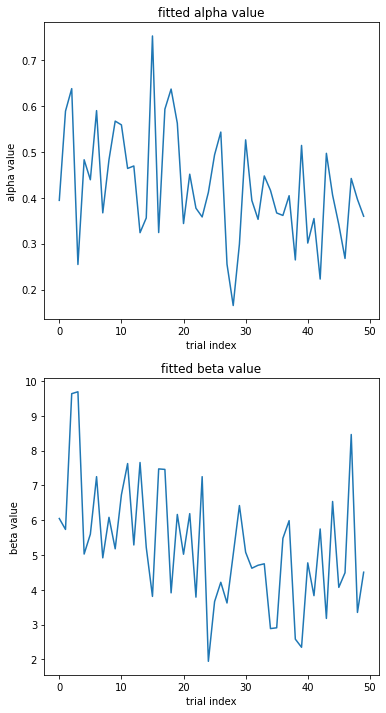

In [153]:
fig, ax = plt.subplots(2, 1, figsize=(6, 12))
ax[0].plot(fitted_alphas)
ax[1].plot(fitted_betas)
ax[0].set_title('fitted alpha value')
ax[1].set_title('fitted beta value')
ax[0].set_xlabel('trial index')
ax[0].set_ylabel('alpha value')
ax[1].set_xlabel('trial index')
ax[1].set_ylabel('beta value')
plt.show()



## Task F Group Comparison

*Use a two sample t-test (describe which exact test you are using) to test whether the estimated parameter
values (Task (e)) are significantly different across groups (again, consider the first 25 participants as your
high anxious group). Report the t statistic, degrees of freedom and p value if applicable. Make sure the
estimated parameter values you use for this test make sense. Explain briefly how we can interpret the results
and how this relates to our hypotheses. What might we conclude if the data was real?*

scipy.stats.ttest_ind calculates the t test for the mean of two independent group of data

It tests the null hypothesis that the two groups have identical expected value. When equal_var is set to False, performs Welch’s t-test.

In [154]:
# test alpha
alpha_t, alpha_p = scipy.stats.ttest_ind(fitted_alphas[:25], fitted_alphas[25:], equal_var=False)
beta_t, beta_p = scipy.stats.ttest_ind(fitted_betas[:25], fitted_betas[25:], equal_var=False)

print('The t statistics for alpha is %.3f, the p value for alpha is %.3f' % (alpha_t, alpha_p))
print('The t statistics for beta is %.3f, the p value for beta is %.3f' % (beta_t, beta_p))

The t statistics for alpha is 3.033, the p value for alpha is 0.004
The t statistics for beta is 3.303, the p value for beta is 0.002


As can be seen from the p value, the hypothesis that alpha and beta has equal expected values can be rejected with 1% or 0.5% threshold

## Task G Parameter recovery

*We now want to check the reliability and identifiability of our parameter estimates. Sample 50 sets of
parameter values of learning rate and inverse temperature from a multivariate normal distributions. Choose sensible numbers for the mean of this distribution and describe how you chose them; choose small numbers
for the variance (e.g. 0.01 and 0.5 for α and β respectively); set the covariance to zero. Illustrate the sampled
values and highlight and exclude (resample) nonsensical values*

Use the mean of the 50 fitted alpha and beta as our sample mean, and 0.01 and 0.5 as the variance for alpha and beta

In [155]:
mean = np.array([fitted_alphas.mean(), fitted_betas.mean()])
covars = np.array([[0.01, 0],
                 [0, 0.5]])

samples = np.random.multivariate_normal(mean=mean, cov=covars, size=50)

alphas = samples[:, 0]
betas = samples[:, 1]

*Use the sampled parameter values to simulate 50 sets of data (as in Task (b)). Fit new parameter values to
these simulated data sets (as in Task (e)). Calculate, report and illustrate the Pearson’s correlation between
the parameter values you used to simulate the data and the parameter values that you obtained from fitting
the model to the simulated data.
Repeat this process 5 times and report the Pearson’s correlation each time (there is no need for you to plot
the sampled values all 5 times, the correlation coefficients are enough).*

In [156]:
model = ModelA()
fitted_params = []

for i in range(50):
    alpha = alphas[i]
    beta = betas[i]

    model.test_trial(160, alpha, beta, 0.5, 0.5)
    fitted_params.append(scipy.optimize.minimize(model.nll, x0=[0.3, 8], args=(model.choices, model.outcomes), method='Nelder-Mead')['x'])

fitted_params = np.array(fitted_params)
print('alphas correlation is %.4f\nbetas correlation is %.4f' % (np.corrcoef(alphas, fitted_params[:, 0])[0, 1], np.corrcoef(betas, fitted_params[:, 1])[0, 1]))

alphas correlation is 0.6721
betas correlation is 0.5222


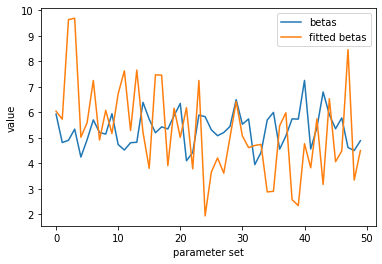

In [157]:
fig, ax = plt.subplots(1, 1)
ax.plot(betas, label='betas')
ax.plot(fitted_betas, label='fitted betas')
ax.legend()
ax.set_xlabel('parameter set')
ax.set_ylabel('value')
plt.show()

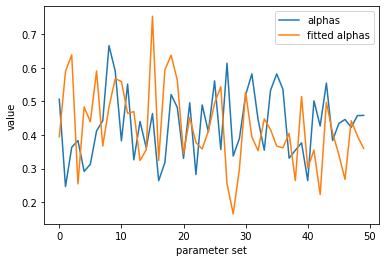

In [158]:
fig, ax = plt.subplots(1, 1)
ax.plot(alphas, label='alphas')
ax.plot(fitted_alphas, label='fitted alphas')
ax.legend()
ax.set_xlabel('parameter set')
ax.set_ylabel('value')
plt.show()

In [159]:
for i in range(5):    
    model = ModelA()

    samples = np.random.multivariate_normal(mean=mean, cov=covars, size=50)

    alphas = samples[:, 0]
    betas = samples[:, 1]
    fitted_params = []

    for i in range(50):
        alpha = alphas[i]
        beta = betas[i]

        model.test_trial(160, alpha, beta, 0.5, 0.5)
        fitted_params.append(scipy.optimize.minimize(model.nll, x0=[0.3, 8, 0.5], args=(model.choices, model.outcomes), method='Nelder-Mead')['x'])

    fitted_params = np.array(fitted_params)
    print('alphas correlation is %.4f\nbetas correlation is %.4f' % (np.corrcoef(alphas, fitted_params[:, 0])[0, 1], np.corrcoef(betas, fitted_params[:, 1])[0, 1]))

alphas correlation is 0.8373
betas correlation is 0.5032
alphas correlation is 0.7455
betas correlation is 0.5523
alphas correlation is 0.7681
betas correlation is 0.4677
alphas correlation is 0.6262
betas correlation is 0.5239
alphas correlation is 0.7633
betas correlation is 0.2260


The correlation between simulated and recovered alphas are usually very high, while the correlation between the betas are less prominent, and can be almost non-existent at some occasions

## Task H Alternative Model

*In addition to model 1, which you already implemented, we will now be considering an additional model.
Model 2 introduces a parameter A. What is the effect of A in this model? How it can be interpreted?*

$V_i^{(t+1)} = A \times V_i^{(t)} + \alpha \times (o^{(t)} - V_i^{(t)})$

A can be interpreted as a decay value for the previous state estimation

In [160]:
class ModelB:
    def _init_(self):
        self.alpha = 0
        self.beta = 0
        self.A = 0
        self.V = [0, 0]
        self.choices = []
        self.diff = [] # array of Va - Vb
        self.averse = 0 # number of aversive signals received in a trial
        self.nnl = 0
    
    def make_choice(self):
        if (np.exp(-self.beta*self.V[0]) + np.exp(-self.beta*self.V[1])) == 0:
            prob = 0
        else:
            prob = np.exp(-self.beta * self.V[0]) / (np.exp(-self.beta*self.V[0]) + np.exp(-self.beta*self.V[1]))
        choice = binom(1, 1-prob).rvs() + 1
        return choice
    
    def outcome(self, trial_ind, choice):
        noise_prob = [0.6, 0.8, 0.6, 0.65] # posibility of choosing A resulting in noise_prob
        if choice == 1:
            chance = noise_prob[math.floor((trial_ind / 40) % 4)]
        else:
            chance = 1 - noise_prob[math.floor((trial_ind / 40) % 4)]
        if binom(1, chance).rvs():
            self.averse += 1
            return 1
        else:
            return 0

    def update(self, choice, trial_ind):
        outcome = self.outcome(trial_ind, choice)
        self.V[choice - 1] = self.A * self.V[choice - 1]  + self.alpha * (outcome - self.V[choice - 1])
        return outcome

    def test_trial(self, trial_num, alpha, beta, A, va, vb):
        self.averse = 0
        self.choices = []
        self.outcomes = []
        self.diff = [] # Va - Vb
        self.alpha = alpha
        self.beta = beta
        self.A = A
        self.V = [va, vb]

        for i in range(trial_num):
            choice = self.make_choice()
            outcome = self.update(choice, i)
            self.choices.append(choice)
            self.outcomes.append(outcome)
            self.diff.append(self.V[0] - self.V[1])
        
        self.choices = np.array(self.choices)
        self.outcomes = np.array(self.outcomes)


    # calculate the negative log likelihood given the real data and some initial values
    def nll(self, parameters, choices, outcomes):
        choice_prob = []
        self.alpha = parameters[0]
        self.beta = parameters[1]
        self.A = parameters[2]
        self.V = [0.5, 0.5]

        for i in range(choices.size):
            real_choice = choices[i] - 1 # 0 for A and 1 for B
            if (np.exp(-self.beta*self.V[0]) + np.exp(-self.beta*self.V[1])) == 0:
                prob = 0
            else:
                prob = abs(real_choice - np.exp(-self.beta * self.V[0]) / (np.exp(-self.beta*self.V[0]) + np.exp(-self.beta*self.V[1])))
            choice_prob.append(prob)
            self.V[real_choice] = self.A* self.V[real_choice] + self.alpha * (outcomes[i] - self.V[real_choice])
        
        choice_prob = np.array(choice_prob)
        # avoid 0 in log funciton
        choice_prob[choice_prob == 0] = 0.0001
        nll = - np.sum(np.log(choice_prob))

        return nll

In [161]:
model = ModelB()
parameters = []

for i in range(50):
    choices_i = choices.iloc[i]
    outcomes_i = outcomes.iloc[i]
    # extract the optimized parameters
    parameters.append(scipy.optimize.minimize(model.nll, x0=[0.3, 8, 0.5], args=(choices_i, outcomes_i), method='Nelder-Mead')['x'])

parameters = np.array(parameters)
fitted_alphas = parameters[:, 0]
fitted_betas = parameters[:, 1]
fitted_As = parameters[:, 2]

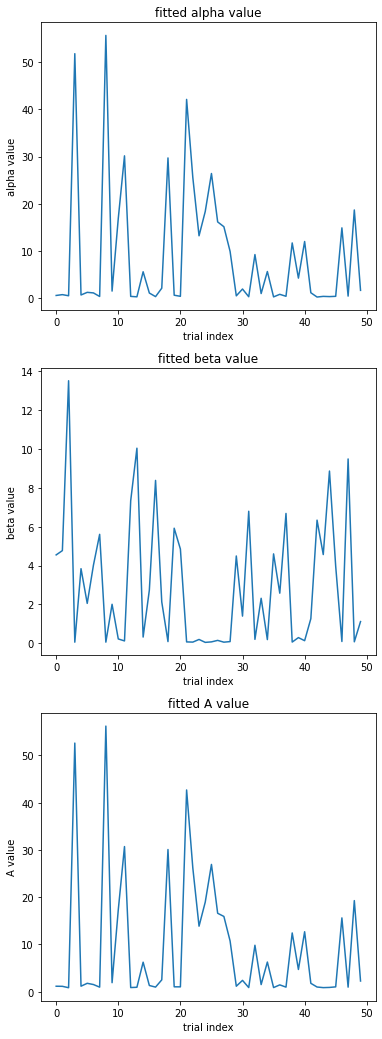

In [162]:
fig, ax = plt.subplots(3, 1, figsize=(6, 18))
ax[0].plot(fitted_alphas)
ax[1].plot(fitted_betas)
ax[2].plot(fitted_As)
ax[0].set_title('fitted alpha value')
ax[1].set_title('fitted beta value')
ax[2].set_title('fitted A value')
ax[0].set_xlabel('trial index')
ax[0].set_ylabel('alpha value')
ax[1].set_xlabel('trial index')
ax[1].set_ylabel('beta value')
ax[2].set_xlabel('trial index')
ax[2].set_ylabel('A value')
plt.show()

The value of $\alpha$ and A are much larger than our starting value, and $\alpha$ in model B is much larger than the ones in model A, which seems a bit strange.

The value of alpha and A have almost exactly the same shape, it seems that they are increased proportionally

This may be helped by constrained optimization, limiting A and $\alpha$ to [0, 1] by adding constaint of $A + \alpha = 1$. Since Nelder-Mead cannot handle constraints, we are just using 

C:\Users\13954\AppData\Local\Temp\ipykernel_14016\3343199136.py:68: RuntimeWarning: overflow encountered in exp
  if (np.exp(-self.beta*self.V[0]) + np.exp(-self.beta*self.V[1])) == 0:
C:\Users\13954\AppData\Local\Temp\ipykernel_14016\3343199136.py:71: RuntimeWarning: overflow encountered in exp
  prob = abs(real_choice - np.exp(-self.beta * self.V[0]) / (np.exp(-self.beta*self.V[0]) + np.exp(-self.beta*self.V[1])))
C:\Users\13954\AppData\Local\Temp\ipykernel_14016\3343199136.py:71: RuntimeWarning: invalid value encountered in double_scalars
  prob = abs(real_choice - np.exp(-self.beta * self.V[0]) / (np.exp(-self.beta*self.V[0]) + np.exp(-self.beta*self.V[1])))


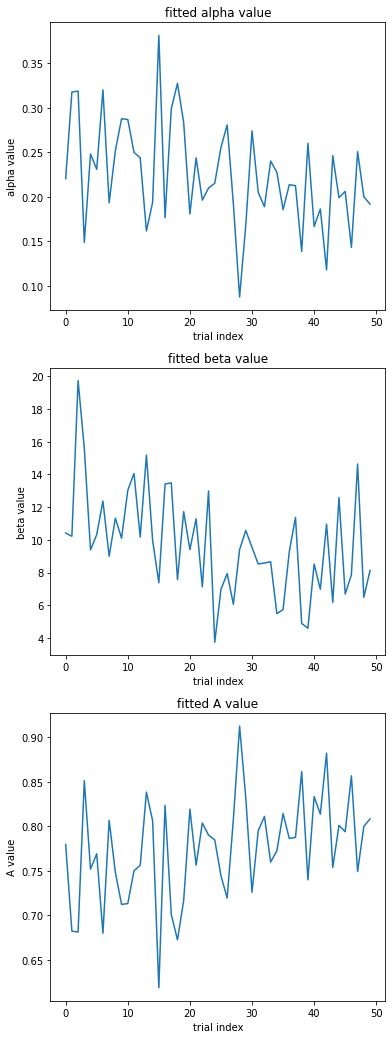

In [163]:
# constraint, A + alpha == 1
def con(t):
    return t[0] + t[2] - 1

cons = {'type': 'eq', 'fun': con}

model = ModelB()
parameters = []

for i in range(50):
    choices_i = choices.iloc[i]
    outcomes_i = outcomes.iloc[i]
    # extract the optimized parameters
    parameters.append(scipy.optimize.minimize(model.nll, x0=[0.3, 8, 0.5], args=(choices_i, outcomes_i), constraints=cons)['x'])

parameters = np.array(parameters)
fitted_alphas = parameters[:, 0]
fitted_betas = parameters[:, 1]
fitted_As = parameters[:, 2]

fig, ax = plt.subplots(3, 1, figsize=(6, 18))
ax[0].plot(fitted_alphas)
ax[1].plot(fitted_betas)
ax[2].plot(fitted_As)
ax[0].set_title('fitted alpha value')
ax[1].set_title('fitted beta value')
ax[2].set_title('fitted A value')
ax[0].set_xlabel('trial index')
ax[0].set_ylabel('alpha value')
ax[1].set_xlabel('trial index')
ax[1].set_ylabel('beta value')
ax[2].set_xlabel('trial index')
ax[2].set_ylabel('A value')
plt.show()

## Task I Model Comparison
*For each participant you should now have two negative log likelihood values: One for each model (using
the estimated optimal parameters). Compare these negative log likelihood values between models. Explain
what you observe. Does it make sense?*

In [164]:
model = ModelA()
nll_A = []

for i in range(50):
    choices_i = choices.iloc[i]
    outcomes_i = outcomes.iloc[i]
    # extract the optimized parameters
    x = scipy.optimize.minimize(model.nll, x0=[0.3, 8], args=(choices_i, outcomes_i), method='Nelder-Mead')['x']
    nll_A.append(model.nll(x, choices_i, outcomes_i))

model = ModelB()
nll_B = []

for i in range(50):
    choices_i = choices.iloc[i]
    outcomes_i = outcomes.iloc[i]
    # extract the optimized parameters
    x = scipy.optimize.minimize(model.nll, x0=[0.3, 8, 0.5], args=(choices_i, outcomes_i), method='Nelder-Mead')['x']
    nll_B.append(model.nll(x, choices_i, outcomes_i))

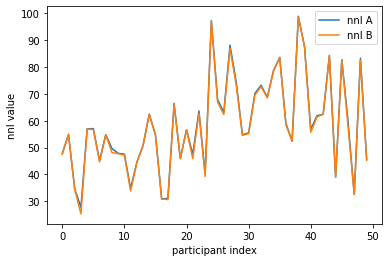

In [165]:
plt.plot(nll_A, label='nnl A')
plt.plot(nll_B, label='nnl B')
plt.xlabel('participant index')
plt.ylabel('nnl value')
plt.legend()

The nll of the two participants are rather consistent, with model B having slightly lower nll than A at some occasions


*For each participant, compute AIC and BIC scores for each model. Sum up the participant scores for each
model (i.e. for each model you will have a single AIC score and a single BIC score). Report the results.
Comment briefly. Which model would you choose as the “best” model?*

*For your reference, use the following equations for the calculations of AIC and BIC, where NLL is the
negative log likelihood, p is the number of parameters, and n is the number of observations (160 in our
experiment):*

$$
AIC = 2 \times NLL + 2 \times p
$$
$$
BIC = 2 \times NLL + p \times \log(n)
$$

Text(0.5, 1.0, 'BIC score')

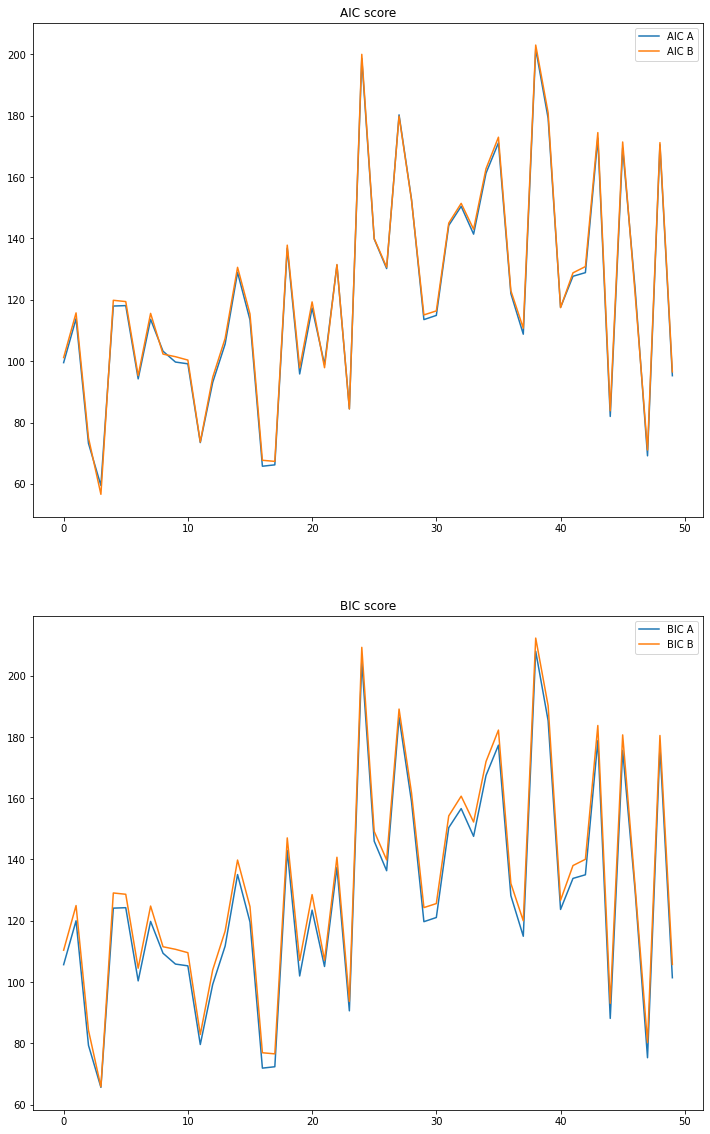

In [166]:
nll_A = np.array(nll_A)
nll_B = np.array(nll_B)

AIC_A = 2 * nll_A + 2 * 2
AIC_B = 2 * nll_B + 2 * 3

BIC_A = 2 * nll_A + 2 * np.log(160)
BIC_B = 2 * nll_B + 3 * np.log(160)

fig, axes = plt.subplots(2, 1, figsize=(12, 20))
axes[0].plot(AIC_A, label='AIC A')
axes[0].plot(AIC_B, label='AIC B')
axes[0].legend()
axes[0].set_title('AIC score')
axes[1].plot(BIC_A, label='BIC A')
axes[1].plot(BIC_B, label='BIC B')
axes[1].legend()
axes[1].set_title('BIC score')

Both are still rather consistent, with model A having slightly lower AIC and BIC score at some occasions.

The difference in BIC scores are a lot more prominent than AIC score

## Task J Model recovery and confusion matrix

*We now want to check the reliability of our model comparison procedure using model recovery simulations.
This will give us some indication about how much we can trust our results from Task (h). For each model,
simulate data (using the functions you already implemented) multiple times. For each of these simulated
data set, fit each model and use model comparison (i.e., the AIC and BIC scores) to choose the best model.
Display your results in a confusion matrix. Comment briefly. (Make sure to explain your approach and
results in appropriate detail.)*

In [167]:
# generating the data with both models

choices_gen = []
outcomes_gen = []

# sample 10 alpha and beta value for model A
model = ModelA()
parameters = []

for i in range(50):
    choices_i = choices.iloc[i]
    outcomes_i = outcomes.iloc[i]
    parameters.append(scipy.optimize.minimize(model.nll, x0=[0.3, 8], args=(choices_i, outcomes_i), method='Nelder-Mead')['x'])

parameters = np.array(parameters)
fitted_alphas = parameters[:, 0]
fitted_betas = parameters[:, 1]
mean = np.array([fitted_alphas.mean(), fitted_betas.mean()])
covars = np.array([[0.01, 0],
                   [0, 0.5]])

samples = np.random.multivariate_normal(mean=mean, cov=covars, size=10)

for i in range(10):
    alpha = samples[i, 0]
    beta = samples[i, 1]

    model.test_trial(160, alpha, beta, 0.5, 0.5)
    choices_gen.append(model.choices)
    outcomes_gen.append(model.outcomes)


# sample 10 alpha, beta and A value for model B
model = ModelB()
parameters = []

for i in range(50):
    choices_i = choices.iloc[i]
    outcomes_i = outcomes.iloc[i]
    parameters.append(scipy.optimize.minimize(model.nll, x0=[0.3, 8, 0.5], args=(choices_i, outcomes_i), method='Nelder-Mead')['x'])

parameters = np.array(parameters)
fitted_alphas = parameters[:, 0]
fitted_betas = parameters[:, 1]
fitted_As = parameters[:, 2]
mean = np.array([fitted_alphas.mean(), fitted_betas.mean(), fitted_As.mean()])
covars = np.array([[0.01, 0, 0],
                   [0, 0.5, 0],
                   [0, 0, 0.1]])

samples = np.random.multivariate_normal(mean=mean, cov=covars, size=10)

for i in range(10):
    alpha = samples[i, 0]
    beta = samples[i, 1]
    A = samples[i, 2]

    model.test_trial(160, alpha, beta, A, 0.5, 0.5)
    choices_gen.append(model.choices)
    outcomes_gen.append(model.outcomes)

C:\Users\13954\AppData\Local\Temp\ipykernel_14016\1196639116.py:75: RuntimeWarning: divide by zero encountered in log
  nll = - np.sum(np.log(choice_prob))
C:\Users\13954\AppData\Local\Temp\ipykernel_14016\3343199136.py:78: RuntimeWarning: divide by zero encountered in log
  nll = - np.sum(np.log(choice_prob))
C:\Users\13954\AppData\Local\Temp\ipykernel_14016\3343199136.py:68: RuntimeWarning: overflow encountered in exp
  if (np.exp(-self.beta*self.V[0]) + np.exp(-self.beta*self.V[1])) == 0:
C:\Users\13954\AppData\Local\Temp\ipykernel_14016\3343199136.py:71: RuntimeWarning: overflow encountered in exp
  prob = abs(real_choice - np.exp(-self.beta * self.V[0]) / (np.exp(-self.beta*self.V[0]) + np.exp(-self.beta*self.V[1])))


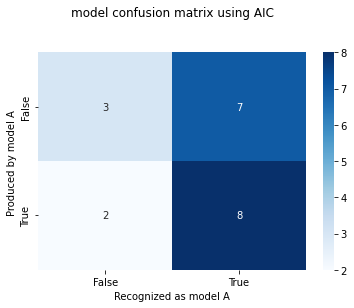

In [168]:
cf_matrix_AIC = np.array([[0, 0],
                          [0, 0]])


for i in range(10):
    model = ModelA()
    x = scipy.optimize.minimize(model.nll, x0=[0.3, 8], args=(choices[i], outcomes[i]), method='Nelder-Mead')['x']
    AIC_A = model.nll(x, choices[i], outcomes[i]) * 2 + 2 * 2
    model = ModelB()
    x = scipy.optimize.minimize(model.nll, x0=[0.3, 8, 0.5], args=(choices[i], outcomes[i]), method='Nelder-Mead')['x']
    AIC_B = model.nll(x, choices[i], outcomes[i]) * 2 + 2 * 3
    if AIC_A < AIC_B:
        cf_matrix_AIC[1, 1] += 1
    else:
        cf_matrix_AIC[1, 0] += 1 

for i in range(10, 20, 1):
    model = ModelA()
    x = scipy.optimize.minimize(model.nll, x0=[0.3, 8], args=(choices[i], outcomes[i]), method='Nelder-Mead')['x']
    AIC_A = model.nll(x, choices[i], outcomes[i]) * 2 + 2 * 2
    model = ModelB()
    x = scipy.optimize.minimize(model.nll, x0=[0.3, 8, 0.5], args=(choices[i], outcomes[i]), method='Nelder-Mead')['x']
    AIC_B = model.nll(x, choices[i], outcomes[i]) * 2 + 2 * 3
    if AIC_A < AIC_B:
        cf_matrix_AIC[0, 1] += 1
    else:
        cf_matrix_AIC[0, 0] += 1     

ax = sns.heatmap(cf_matrix_AIC, annot=True, cmap='Blues')

ax.set_title('model confusion matrix using AIC\n\n')
ax.set_xlabel('Recognized as model A')
ax.set_ylabel('Produced by model A ')

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

C:\Users\13954\AppData\Local\Temp\ipykernel_14016\1196639116.py:75: RuntimeWarning: divide by zero encountered in log
  nll = - np.sum(np.log(choice_prob))
C:\Users\13954\AppData\Local\Temp\ipykernel_14016\3343199136.py:78: RuntimeWarning: divide by zero encountered in log
  nll = - np.sum(np.log(choice_prob))
C:\Users\13954\AppData\Local\Temp\ipykernel_14016\3343199136.py:68: RuntimeWarning: overflow encountered in exp
  if (np.exp(-self.beta*self.V[0]) + np.exp(-self.beta*self.V[1])) == 0:
C:\Users\13954\AppData\Local\Temp\ipykernel_14016\3343199136.py:71: RuntimeWarning: overflow encountered in exp
  prob = abs(real_choice - np.exp(-self.beta * self.V[0]) / (np.exp(-self.beta*self.V[0]) + np.exp(-self.beta*self.V[1])))


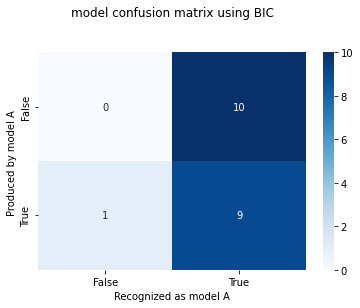

In [169]:
cf_matrix_BIC = np.array([[0, 0],
                          [0, 0]])

for i in range(10):
    model = ModelA()
    x = scipy.optimize.minimize(model.nll, x0=[0.3, 8], args=(choices[i], outcomes[i]), method='Nelder-Mead')['x']
    BIC_A = model.nll(x, choices[i], outcomes[i]) * 2 + 2 * np.log(160)
    model = ModelB()
    x = scipy.optimize.minimize(model.nll, x0=[0.3, 8, 0.5], args=(choices[i], outcomes[i]), method='Nelder-Mead')['x']
    BIC_B = model.nll(x, choices[i], outcomes[i]) * 2 + 3 * np.log(160)
    if BIC_A < BIC_B:
        cf_matrix_BIC[1, 1] += 1
    else:
        cf_matrix_BIC[1, 0] += 1 

for i in range(10, 20, 1):
    model = ModelA()
    x = scipy.optimize.minimize(model.nll, x0=[0.3, 8], args=(choices[i], outcomes[i]), method='Nelder-Mead')['x']
    BIC_A = model.nll(x, choices[i], outcomes[i]) * 2 + 2 * np.log(160)
    model = ModelB()
    x = scipy.optimize.minimize(model.nll, x0=[0.3, 8, 0.5], args=(choices[i], outcomes[i]), method='Nelder-Mead')['x']
    BIC_B = model.nll(x, choices[i], outcomes[i]) * 2 + 3 * np.log(160)
    if BIC_A < BIC_B:
        cf_matrix_BIC[0, 1] += 1
    else:
        cf_matrix_BIC[0, 0] += 1     

ax = sns.heatmap(cf_matrix_BIC, annot=True, cmap='Blues')

ax.set_title('model confusion matrix using BIC\n\n')
ax.set_xlabel('Recognized as model A')
ax.set_ylabel('Produced by model A ')

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

As shown by the confusion matrices, model A seems to be the better model of the two

Model A performs better on most data generated by model A, as well as on most data generated by model B. With the advantage being more prominent when using BIC

## Task K Discussion and extra model


In [170]:
class ModelC:
    def _init_(self):
        self.alpha_p = 0
        self.alpha_n = 0
        self.beta = 0
        self.V = [0, 0]
        self.choices = []
        self.diff = [] # array of V_a - V_b
        self.averse = 0 # number of aversive signals received in a trial
        self.nnl = 0
    
    def make_choice(self):
        if (np.exp(-self.beta*self.V[0]) + np.exp(-self.beta*self.V[1])) == 0:
            prob = 0
        else:
            prob = np.exp(-self.beta * self.V[0]) / (np.exp(-self.beta*self.V[0]) + np.exp(-self.beta*self.V[1]))
        # binom(1, 1-prob).rvs() returns 0 if A is chosen, and 1 if B is chosen
        choice = binom(1, 1-prob).rvs() + 1
        return choice
    
    def outcome(self, trial_ind, choice):
        noise_prob = [0.6, 0.8, 0.6, 0.65] # posibility of choosing A resulting in noise_prob
        if choice == 1:
            chance = noise_prob[math.floor((trial_ind / 40) % 4)]
        else:
            chance = 1 - noise_prob[math.floor((trial_ind / 40) % 4)]
        if binom(1, chance).rvs():
            self.averse += 1
            return 1
        else:
            return 0

    def update(self, choice, trial_ind):
        outcome = self.outcome(trial_ind, choice)
        self.V[choice - 1] = self.V[choice - 1]  + (self.alpha_p * (1 - outcome) + self.alpha_n * outcome) * (outcome - self.V[choice - 1])
        
        return outcome

    def test_trial(self, trial_num, alpha_p, alpha_n, beta, va, vb):
        self.averse = 0
        self.choices = []
        self.outcomes = []
        self.diff = [] # Va - Vb
        self.alpha_p = alpha_p
        self.alpha_n = alpha_n
        self.beta = beta
        self.V = [va, vb]

        for i in range(trial_num):
            choice = self.make_choice()
            outcome = self.update(choice, i)
            self.choices.append(choice)
            self.outcomes.append(outcome)
            self.diff.append(self.V[0] - self.V[1])
        
        self.choices = np.array(self.choices)
        self.outcomes = np.array(self.outcomes)


    # calculate the negative log likelihood given the real data and some initial values
    def nll(self, parameters, choices, outcomes):
        choice_prob = []
        self.alpha_p = parameters[0]
        self.alpha_n = parameters[1]
        self.beta = parameters[2]
        self.V = [0.5, 0.5]

        for i in range(choices.size):
            real_choice = choices[i] - 1 # 0 for A and 1 for B
            if (np.exp(-self.beta*self.V[0]) + np.exp(-self.beta*self.V[1])) == 0:
                prob = 0
            else:
                prob = abs(real_choice - np.exp(-self.beta * self.V[0]) / (np.exp(-self.beta*self.V[0]) + np.exp(-self.beta*self.V[1])))
            choice_prob.append(prob)
            self.V[real_choice] = self.V[real_choice] +  (self.alpha_p * (1 - outcomes[i]) + self.alpha_n * outcomes[i])* (outcomes[i] - self.V[real_choice])
        
        choice_prob = np.array(choice_prob)
        choice_prob[choice_prob == 0] = 0.0001
        nll = - np.sum(np.log(choice_prob))

        return nll

In [171]:
model = ModelA()
nll_A = []

for i in range(50):
    choices_i = choices.iloc[i]
    outcomes_i = outcomes.iloc[i]
    # extract the optimized parameters
    x = scipy.optimize.minimize(model.nll, x0=[0.3, 8], args=(choices_i, outcomes_i), method='Nelder-Mead')['x']
    nll_A.append(model.nll(x, choices_i, outcomes_i))

model = ModelB()
nll_B = []

for i in range(50):
    choices_i = choices.iloc[i]
    outcomes_i = outcomes.iloc[i]
    # extract the optimized parameters
    x = scipy.optimize.minimize(model.nll, x0=[0.3, 8, 0.5], args=(choices_i, outcomes_i), method='Nelder-Mead')['x']
    nll_B.append(model.nll(x, choices_i, outcomes_i))

model = ModelC()
nll_C = []

for i in range(50):
    choices_i = choices.iloc[i]
    outcomes_i = outcomes.iloc[i]
    # extract the optimized parameters
    x = scipy.optimize.minimize(model.nll, x0=[0.25, 0.35, 6], args=(choices_i, outcomes_i), method='Nelder-Mead')['x']
    nll_C.append(model.nll(x, choices_i, outcomes_i))

Text(0.5, 1.0, 'BIC score')

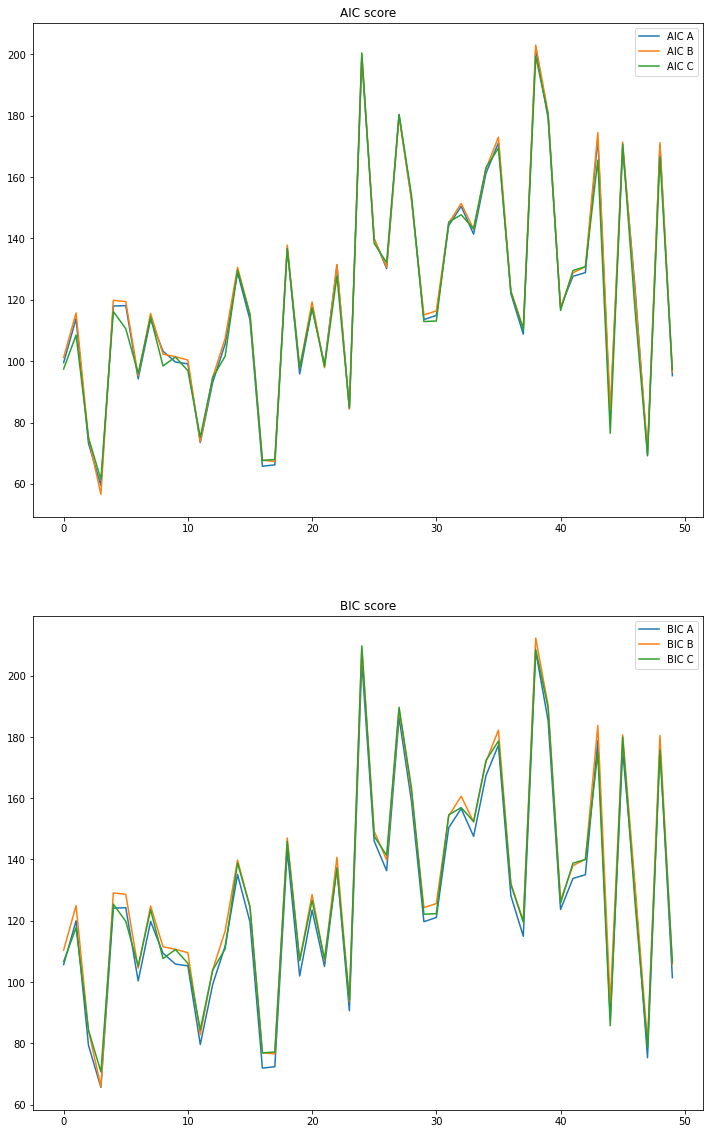

In [172]:
nll_A = np.array(nll_A)
nll_B = np.array(nll_B)
nll_C = np.array(nll_C)

AIC_A = 2 * nll_A + 2 * 2
AIC_B = 2 * nll_B + 2 * 3
AIC_C = 2 * nll_C + 2 * 3

BIC_A = 2 * nll_A + 2 * np.log(160)
BIC_B = 2 * nll_B + 3 * np.log(160)
BIC_C = 2 * nll_C + 3 * np.log(160)

fig, axes = plt.subplots(2, 1, figsize=(12, 20))
axes[0].plot(AIC_A, label='AIC A')
axes[0].plot(AIC_B, label='AIC B')
axes[0].plot(AIC_C, label='AIC C')
axes[0].legend()
axes[0].set_title('AIC score')
axes[1].plot(BIC_A, label='BIC A')
axes[1].plot(BIC_B, label='BIC B')
axes[1].plot(BIC_C, label='BIC C')
axes[1].legend()
axes[1].set_title('BIC score')

In [173]:
# sample 10 alpha_p, alpha_n and beta value for model B
model = ModelC()
parameters = []

for i in range(50):
    choices_i = choices.iloc[i]
    outcomes_i = outcomes.iloc[i]
    parameters.append(scipy.optimize.minimize(model.nll, x0=[0.25, 0.35, 6], args=(choices_i, outcomes_i), method='Nelder-Mead')['x'])

parameters = np.array(parameters)
fitted_alphas_p = parameters[:, 0]
fitted_alphas_n = parameters[:, 1]
fitted_betas = parameters[:, 2]
mean = np.array([fitted_alphas_p.mean(), fitted_alphas_n.mean(), fitted_betas.mean()])
covars = np.array([[0.01, 0, 0],
                   [0, 0.01, 0],
                   [0, 0, 0.5]])

samples = np.random.multivariate_normal(mean=mean, cov=covars, size=10)
print(samples)

[[ 0.29861292  0.53835674 11.94263081]
 [ 0.24942639  0.61905173 12.21027455]
 [ 0.0961606   0.47238663 10.90383116]
 [ 0.20985278  0.52594983 10.99380067]
 [ 0.2482974   0.40584938 11.86150464]
 [ 0.41046819  0.32163433 10.69736662]
 [ 0.40338467  0.50704476 11.30662215]
 [ 0.31994573  0.52733099 11.34705667]
 [ 0.40098972  0.62072971 11.85624597]
 [ 0.28314134  0.44634679 11.34507682]]


In [174]:
for i in range(10):
    alpha_p = samples[i, 0]
    alpha_n = samples[i, 1]
    beta = samples[i, 2]

    model.test_trial(160, alpha_p, alpha_n, beta, 0.5, 0.5)
    outcomes_gen.append(model.outcomes)
    choices_gen.append(model.choices)

C:\Users\13954\AppData\Local\Temp\ipykernel_14016\19563616.py:79: RuntimeWarning: divide by zero encountered in log
  nll = - np.sum(np.log(choice_prob))
C:\Users\13954\AppData\Local\Temp\ipykernel_14016\1196639116.py:75: RuntimeWarning: divide by zero encountered in log
  nll = - np.sum(np.log(choice_prob))
C:\Users\13954\AppData\Local\Temp\ipykernel_14016\3343199136.py:78: RuntimeWarning: divide by zero encountered in log
  nll = - np.sum(np.log(choice_prob))
C:\Users\13954\AppData\Local\Temp\ipykernel_14016\3343199136.py:68: RuntimeWarning: overflow encountered in exp
  if (np.exp(-self.beta*self.V[0]) + np.exp(-self.beta*self.V[1])) == 0:
C:\Users\13954\AppData\Local\Temp\ipykernel_14016\3343199136.py:71: RuntimeWarning: overflow encountered in exp
  prob = abs(real_choice - np.exp(-self.beta * self.V[0]) / (np.exp(-self.beta*self.V[0]) + np.exp(-self.beta*self.V[1])))


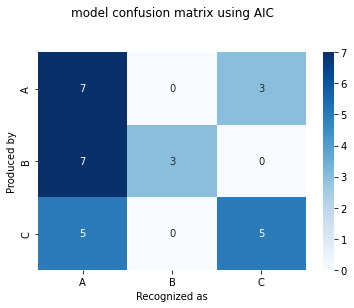

In [177]:
cf_matrix_AIC = np.array([[0, 0, 0],
                          [0, 0, 0],
                          [0, 0, 0]])


for i in range(10):
    model = ModelA()
    x = scipy.optimize.minimize(model.nll, x0=[0.3, 8], args=(choices[i], outcomes[i]), method='Nelder-Mead')['x']
    AIC_A = model.nll(x, choices[i], outcomes[i]) * 2 + 2 * 2
    model = ModelB()
    x = scipy.optimize.minimize(model.nll, x0=[0.3, 8, 0.5], args=(choices[i], outcomes[i]), method='Nelder-Mead')['x']
    AIC_B = model.nll(x, choices[i], outcomes[i]) * 2 + 2 * 3
    model = ModelC()
    x = scipy.optimize.minimize(model.nll, x0=[0.25, 0.35, 6], args=(choices[i], outcomes[i]), method='Nelder-Mead')['x']
    AIC_C = model.nll(x, choices[i], outcomes[i]) * 2 + 2 * 3
    best = np.argmin([AIC_A, AIC_B, AIC_C])
    cf_matrix_AIC[0, best] += 1

for i in range(10, 20, 1):
    model = ModelA()
    x = scipy.optimize.minimize(model.nll, x0=[0.3, 8], args=(choices[i], outcomes[i]), method='Nelder-Mead')['x']
    AIC_A = model.nll(x, choices[i], outcomes[i]) * 2 + 2 * 2
    model = ModelB()
    x = scipy.optimize.minimize(model.nll, x0=[0.3, 8, 0.5], args=(choices[i], outcomes[i]), method='Nelder-Mead')['x']
    AIC_B = model.nll(x, choices[i], outcomes[i]) * 2 + 2 * 3
    model = ModelC()
    x = scipy.optimize.minimize(model.nll, x0=[0.25, 0.35, 6], args=(choices[i], outcomes[i]), method='Nelder-Mead')['x']
    AIC_C = model.nll(x, choices[i], outcomes[i]) * 2 + 2 * 3
    best = np.argmin([AIC_A, AIC_B, AIC_C])
    cf_matrix_AIC[1, best] += 1  

for i in range(20, 30, 1):
    model = ModelA()
    x = scipy.optimize.minimize(model.nll, x0=[0.3, 8], args=(choices[i], outcomes[i]), method='Nelder-Mead')['x']
    AIC_A = model.nll(x, choices[i], outcomes[i]) * 2 + 2 * 2
    model = ModelB()
    x = scipy.optimize.minimize(model.nll, x0=[0.3, 8, 0.5], args=(choices[i], outcomes[i]), method='Nelder-Mead')['x']
    AIC_B = model.nll(x, choices[i], outcomes[i]) * 2 + 2 * 3
    model = ModelC()
    x = scipy.optimize.minimize(model.nll, x0=[0.25, 0.35, 6], args=(choices[i], outcomes[i]), method='Nelder-Mead')['x']
    AIC_C = model.nll(x, choices[i], outcomes[i]) * 2 + 2 * 3
    best = np.argmin([AIC_A, AIC_B, AIC_C])
    cf_matrix_AIC[2, best] += 1

ax = sns.heatmap(cf_matrix_AIC, annot=True, cmap='Blues')

ax.set_title('model confusion matrix using AIC\n\n')
ax.set_xlabel('Recognized as')
ax.set_ylabel('Produced by')

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['A','B', 'C'])
ax.yaxis.set_ticklabels(['A','B', 'C'])

## Display the visualization of the Confusion Matrix.
plt.show()

Model A still appears to be the best performing model